# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-17 13:48:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [ <=>                ] 201.24M  29.3MB/s    in 6.9s    

2024-10-17 13:48:29 (29.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

model = Ridge(random_state=42)

model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse_for_model = root_mean_squared_error(y_test, preds)
rmse_for_model

9.510160711373397

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [9]:
mean_prediction = np.mean(y_train)

constant_preds = np.full(y_test.shape, mean_prediction)

best_rmse_metric = root_mean_squared_error(y_test, constant_preds)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
from torch.utils.data import Dataset, DataLoader
# сделаем даталоадер (был похожий на семе)
class MyDataset(Dataset):
    def __init__(self, x, y):
        # переводим данные в тензоры сразу при инициализации
        self.x = torch.tensor(x, dtype=torch.float).to(device)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1).to(device)  # делаем вектор (n, 1)
        #.unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {
            "sample": self.x[idx, :],
            "target": self.y[idx]
        }

In [12]:
# делаем даталоадеры
train_dataset = MyDataset(X_train_scaled, y_train)
test_dataset = MyDataset(X_test_scaled, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=128)
test_dataloader = DataLoader(test_dataset, batch_size=128)

In [13]:
# такую структуру кода взял с сема и адаптировал

model_nn = nn.Linear(90, 1).to(device)

lr = 0.001

train_losses = []
val_losses = []
val_losses_rmse = []
# epoch_loss = 0

for epoch in range(10):
    model_nn.train()
    train_loss = 0
    total_train_samples = 0
    for train in tqdm(train_dataloader):
        x_train_local, y_train_local = train['sample'], train['target']
        batch_size = x_train_local.size(0)

        y_pred = model_nn(x_train_local)
        loss_train = torch.mean((y_pred - y_train_local) ** 2)

        # решение проблемы с последним батчем, который может быть меньше, чем другие
        # написали об этой проблеме в чате, последний раз надеюсь заливаю ноутбук в энитаск...
        train_loss += loss_train.item() * batch_size
        total_train_samples += batch_size

        loss_train.backward()
        # нужно отключить градиенты, чтобы не вызывать все через data
        with torch.no_grad():
          model_nn.weight -= lr * model_nn.weight.grad
          model_nn.bias -= lr * model_nn.bias.grad
        model_nn.zero_grad()

    train_losses.append(train_loss / total_train_samples)


    model_nn.eval()
    val_loss = 0
    total_val_samples = 0
    with torch.no_grad():
        for test in tqdm(test_dataloader):
            x_val, y_val = test['sample'].to(device), test['target'].to(device)
            batch_size = x_val.size(0)

            y_pred = model_nn(x_val)
            loss = torch.mean((y_pred - y_val) ** 2)

            val_loss += loss.item() * batch_size
            total_val_samples += batch_size

    val_losses.append(val_loss / total_val_samples)
    val_losses_rmse.append((val_loss / total_val_samples) ** 0.5)

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss / total_train_samples}, Val Loss: {val_loss / total_val_samples}")


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 277422.25296237104, Val Loss: 100.93133384812462


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 94.99433246076724, Val Loss: 91.81305200656948


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 92.28935542153056, Val Loss: 90.94581254127527


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 91.86933590656879, Val Loss: 90.72178719273238


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 91.7553675662769, Val Loss: 90.64863537587608


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 91.71888633219555, Val Loss: 90.6218976335749


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 91.70629548215882, Val Loss: 90.6113461743624


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 91.70176436757825, Val Loss: 90.60693197255908


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 91.70007693306947, Val Loss: 90.60501129908454


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 91.69943727939341, Val Loss: 90.60414778934577


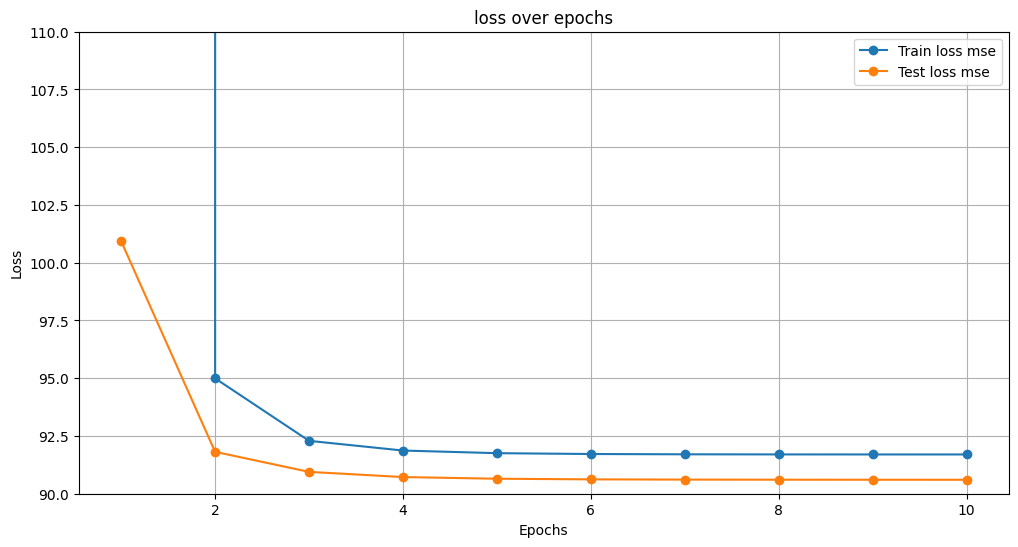

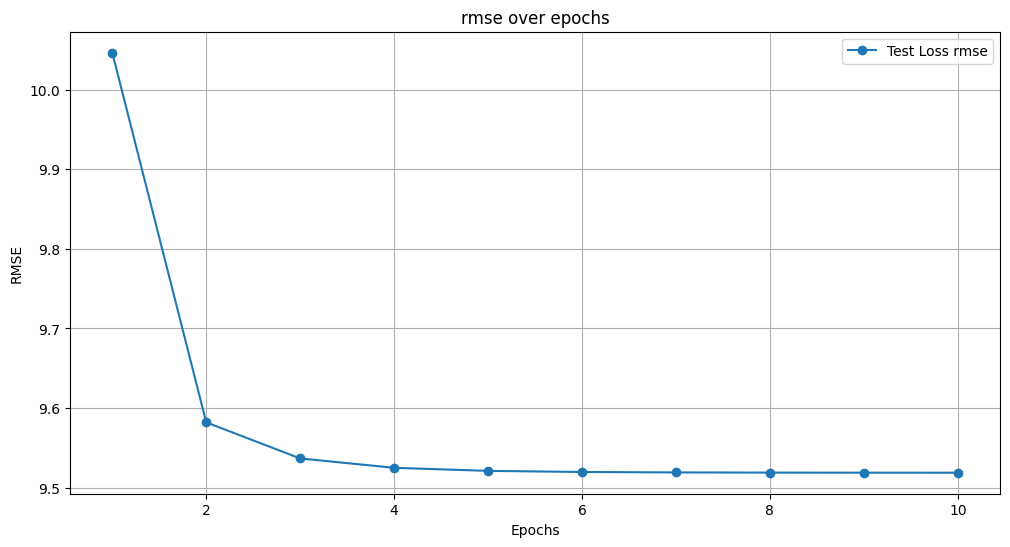

In [14]:
# графики mse train test и rmse test
plt.figure(figsize=(12, 6))
plt.plot(range(1, 10 + 1), train_losses, label='Train loss mse', marker='o')
plt.plot(range(1, 10 + 1), val_losses, label='Test loss mse', marker='o')
plt.ylim(90, 110)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('loss over epochs')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(range(1, 10 + 1), val_losses_rmse, label='Test Loss rmse', marker='o')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('rmse over epochs')
plt.legend()
plt.grid()
plt.show()

Тут на первой эпохе трейна огромный лос, так как он считается как сумма лоссов в батчах за эпоху, а в начале там все плохо, он это не сильно не меняет суть. Теперь посмотрим на RMSE.

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [15]:
# скейлим таргет
target_scaler = StandardScaler()
y_train_normed = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_normed = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

In [16]:
# записываем наши данные
train_set = MyDataset(X_train, y_train_normed)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)

test_set = MyDataset(X_test, y_test_normed)
test_loader = DataLoader(test_set, batch_size=128)

In [17]:
import sys
def train(model, optimizer, criterion, train_loader, test_loader, scheduler):
    model.train()

    train_losses = []
    val_losses_all = []

    for epoch in range(5):
        epoch_loss = 0
        total_train_samples = 0

        for batch in tqdm(train_loader):
            x_train_local_, y_train_local_ = batch['sample'], batch['target']
            y_pred = model(x_train_local_)

            loss = criterion(y_pred.flatten(), y_train_local_.flatten())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = x_train_local_.size(0)
            epoch_loss += loss.item() * batch_size
            total_train_samples += batch_size
            train_losses.append(loss.item())

        avg_train_loss = epoch_loss / total_train_samples

        val_loss, preds = test(model, criterion, test_loader)
        val_losses_all.append(val_loss**0.5)

        print(f"Epoch {epoch + 1}/5, train Loss: {avg_train_loss:.4f}, test mse: {val_loss:.4f}, test rmse: {val_loss**0.5}")
        scheduler.step()

    plot_losses(train_losses, val_losses_all)

def test(model, criterion, test_loader):
    model.eval()
    total_loss = 0
    total_val_samples = 0
    predictions = []

    for batch in tqdm(test_loader):
        x_test, y_test = batch['sample'], batch['target']

        y_pred = model(x_test)
        y_pred = torch.tensor(target_scaler.inverse_transform(y_pred.cpu().detach()))
        y_test = torch.tensor(target_scaler.inverse_transform(y_test.cpu().detach()))

        loss = criterion(y_pred, y_test)
        batch_size = x_test.size(0)
        total_loss += loss.item() * batch_size
        total_val_samples += batch_size
        predictions.append(y_pred)

    predictions = torch.cat(predictions).squeeze()
    avg_loss = total_loss / total_val_samples
    return avg_loss, predictions

def plot_losses(train_losses, val_losses):
    # гладкое усреднение потерь на обучающей выборке, потому что иначе там просто очень странная картинка, так выглядит лучше
    smooth_train_losses = smooth_losses(train_losses, window_size=75)

    plt.figure(figsize=(12, 6))
    plt.plot(smooth_train_losses, label='Train Loss (Smoothed)', color='blue')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Train Loss over Steps')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_losses, label='Test Loss', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Test loss over epochs')
    plt.legend()
    plt.grid()
    plt.show()

def smooth_losses(losses, window_size=5):
    """ Функция для усреднения потерь по скользящему окну """
    return np.convolve(losses, np.ones(window_size)/window_size, mode='valid')


In [18]:
class modelka(nn.Module):
    def __init__(self):
        super(modelka, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(90),
            nn.Linear(90, 180),
            nn.BatchNorm1d(180),
            nn.LeakyReLU(),
            nn.Dropout(0.6),
            nn.Linear(180, 90),
            nn.BatchNorm1d(90),
            nn.LeakyReLU(),
            nn.Dropout(0.6),
            nn.Linear(90, 1)
          )

    def forward(self, x):
        x = self.layers(x)
        return x

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 1/5, train Loss: 0.7361, test mse: 80.5188, test rmse: 8.973225934488365


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 2/5, train Loss: 0.6395, test mse: 77.4448, test rmse: 8.800273749110515


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 3/5, train Loss: 0.6199, test mse: 76.6917, test rmse: 8.757377723175509


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 4/5, train Loss: 0.6065, test mse: 76.7877, test rmse: 8.762856555750652


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch 5/5, train Loss: 0.5961, test mse: 76.0797, test rmse: 8.722367420523433


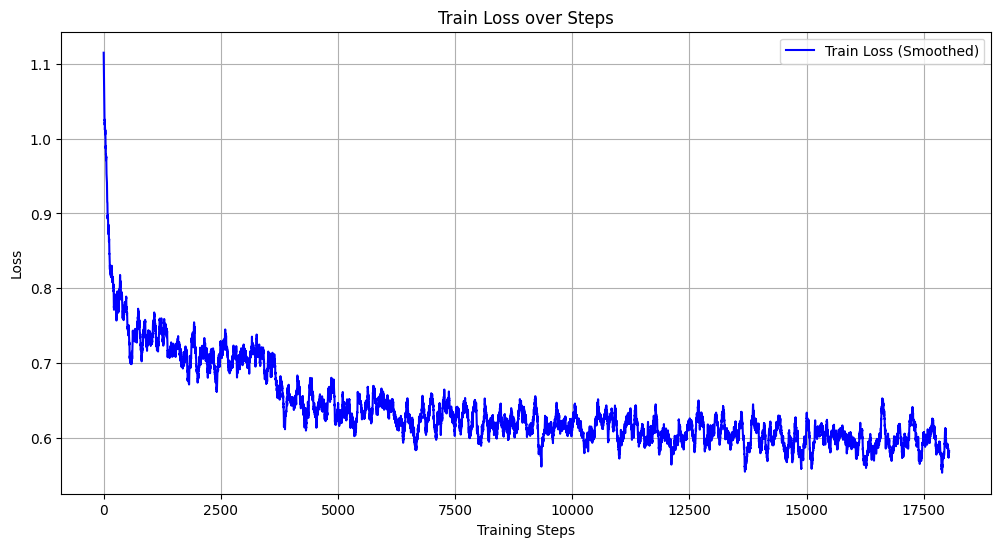

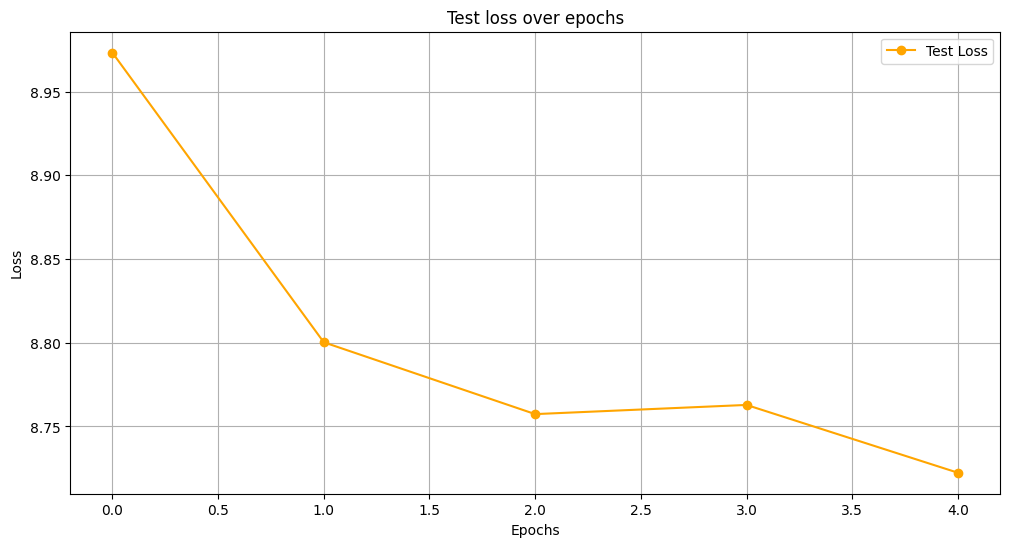

In [19]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR

set_random_seed(42)
model_sim = modelka().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_sim.parameters(), lr=0.001)

# штука, чтобы уменьшать lr с каждой эпохой
lambda1 = lambda epoch: 0.975**epoch
scheduler = LambdaLR(optimizer, lr_lambda=lambda1)

train(model_sim, optimizer, criterion, train_loader, test_loader, scheduler)

In [32]:
test_loss, test_predictions = test(model_sim, criterion, test_loader)
rmse = torch.sqrt(torch.tensor(test_loss)).item()
print(f"Test RMSE: {rmse:.4f}")

  0%|          | 0/404 [00:00<?, ?it/s]

Test RMSE: 8.7224


In [33]:
assert test(model_sim, criterion, test_loader)[1].shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Я начал с развития того кода, который у меня был в задании 1, у меня уже был класс с датасетом, я взял SGD в качестве оптимизатора, 2 слоя и ReLu, но результат был ужасный(rmse больше 10), поэтому сразу перейдем дальше.


Далее я последовал по рекомендации и отскейлил таргет новым скейлером(standard), также я поменял оптимизатор на adam и добавил scheduler, поставил dropout.
Код ниже показывает архитектуру сети, я пробовал менять значения дропаута, но все равно было довольно плохо. Batch Size был всегда 128 во всех экспериментах, потому что иначе качество было хуже.


    class EnhancedNN(nn.Module):
        def __init__(self):
            super(EnhancedNN, self).__init__()
            self.fc1 = nn.Linear(90, 60)
            self.dropout1 = nn.Dropout(0.3)
            self.fc2 = nn.Linear(60, 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

Теперь посмотрим на оптимизаторы. В качестве scheduler был выбран LambdaLR потому что показывал лучшие результаты, я еще пробовал exponentiallr (https://wiki.cloudfactory.com/docs/mp-wiki/scheduler/exponentiallr), но он работал хуже и lr падал слишком быстро

    import torch.optim as optim
    model_sim = EnhancedNN().to(device)
    # criterion = RMSELoss()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_sim.parameters(), lr=0.001)

    lambda_func = lambda epoch: 0.975**epoch
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

    train(model_sim, optimizer, criterion, train_loader, test_loader, scheduler)
    test_loss, test_predictions = test(model_sim, criterion, test_loader)


Гиперпараметры выбирал эмпирически, просто пробовал разные, качество в итоге было около 8.9 - 9, возможно лучше, у меня не сохранилось точных значений, потому что я слишком поздно прочитал 3 задание..

Далее я добавил еще слой в архитектуру, поменял дропауты, оптимизатор и scheduler остались такие же, только чуть чуть уменьшил lr

    class EnhancedNN(nn.Module):
        def __init__(self):
            super(EnhancedNN, self).__init__()
            self.fc1 = nn.Linear(90, 75)
            self.dropout1 = nn.Dropout(0.4)
            self.fc2 = nn.Linear(75, 45)
            self.dropout2 = nn.Dropout(0.5)
            self.fc3 = nn.Linear(45, 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.dropout1(x)
            x = F.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

В итоге качество повысилось до 8.8059
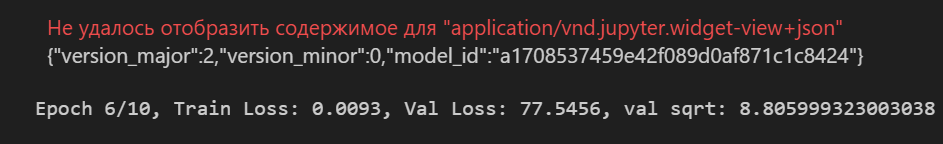












Далее я снова поменял архитектуру, просто поменял количество нейронов и дропаут, также я перепробовал разные функции активации(relu, selu, leaky_relu, gelu), однако особо это не помогало, оптимизаторы оставвались такими же.

    class EnhancedNN(nn.Module):
        def __init__(self):
            super(EnhancedNN, self).__init__()
            self.fc1 = nn.Linear(90, 75)
            self.dropout1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(75, 50)
            self.dropout2 = nn.Dropout(0.5)
            self.fc3 = nn.Linear(50, 1)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.dropout1(x)
            x = F.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

Качество выросло до 8.762

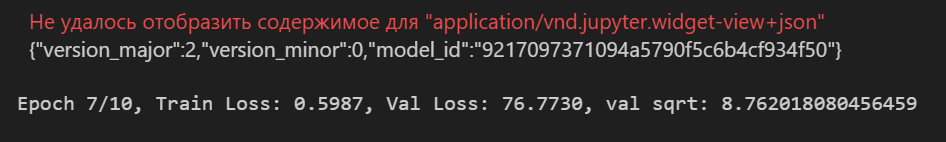

Далее начались проблемы, я никак не мог улучшить качество. добавлял слои, менял количество нейронов, но все без толку. В итоге решил поискать дополнительно про регуляризацию, в итоге нашел batch normalization, плюс это было на лекции. Я пробовал ее добавлять, но было плохо. В качестве эксперимента решил убрать скейлинг трейна и добавить batch normalization, также добавил эту штуку в начало модели. В общем сделал так:


    class EnhancedNN(nn.Module):
        def __init__(self):
            super(EnhancedNN, self).__init__()
            self.norma = nn.BatchNorm1d(90)
            self.fc1 = nn.Linear(90, 75)
            self.norma2 = nn.BatchNorm1d(75)
            self.dropout1 = nn.Dropout(0.5)
            self.fc2 = nn.Linear(75, 50)
            self.dropout2 = nn.Dropout(0.5)
            self.fc3 = nn.Linear(50, 1)
            # self.fc4 = nn.Linear(32, 1)

        def forward(self, x):
            x = self.norma(x)
            x = F.relu(self.fc1(x))
            x = self.norma2(x)
            x = self.dropout1(x)
            x = F.relu(self.fc2(x))
            x = self.dropout2(x)
            x = self.fc3(x)
            return x

Это апнуло качество до 8.75935983209201

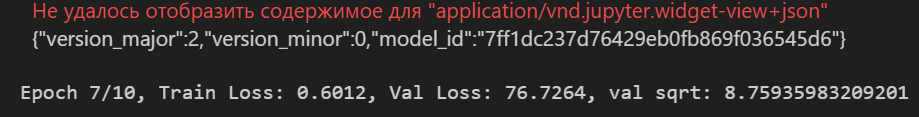

Пока гуглил, я видел, что у многих людей сетки строились по принципу увеличения нейронов после 1 слоя
(https://machinecurve.com/index.php/2021/07/20/how-to-create-a-neural-network-for-regression-with-pytorch)
(https://www.kaggle.com/code/stefancomanita/regression-with-neural-networks-using-pytorc)
Я это пробовал у себя, когда только начинал делать nn, но все было плохо. Сейчас я решил попробовать снова и это дало ощутимый прирост. Также ощутимый прирост дало ставить batch norm до нелинейностей. Смена dropout с 0.5 до 0.6 также улучшило качество. В общем много чего пробовал и получилось круто.


Больше всего информации взял с лекций и семинаров (оптимизаторы) и этих двух сайтов выше, много гуглил и спрашивал у гпт.


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [22]:
# посмотрим сколько у нас классов
classes = np.unique(y_train)
print(len(classes))

89


In [23]:
# у нас классы представлены в виде годов, но при этом формула кросс энтропии требует индексы, то есть от нуля до количества классов - 1,
# чтобы решить эту проблему мы используем лэйбел энкодер, он закодирует наши года, например самый ранний год - 1922 станет 0, затем 1924 станет 1 и так далее
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(classes)

LabelEncoder()

In [24]:
from sklearn.metrics import precision_score, recall_score

def transform_targets(y):
    '''
    для 1 варианта
    Преобразует наш таргет через энкодер, убирает лишнюю размерность и делает тип long,
    '''
    return torch.tensor(label_encoder.transform(y.ravel()), dtype=torch.long)


def train_cl(model, optimizer, criterion, train_loader, test_loader, transformer):
    '''
    Обычный трейн.
    transformer: функция, которая преобразовывает таргет, чтобы loss функция его принимала.
    '''
    model.train()
    for epoch in range(3):
        epoch_loss = 0
        total_train_samples = 0

        for batch in tqdm(train_loader):
            x_train_local_ = batch['sample']
            y_train_local_ = transformer(batch['target'])

            y_pred = model(x_train_local_)
            loss = criterion(y_pred, y_train_local_)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            batch_size = x_train_local_.size(0)
            epoch_loss += loss.item() * batch_size
            total_train_samples += batch_size

        avg_train_loss = epoch_loss / total_train_samples

        predicts, total_loss, accuracy, precision, recall = test_classification(model, criterion, test_loader, transformer)

        print(f"Epoch {epoch + 1}/3, Train Loss: {avg_train_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

def test_classification(model, criterion, test_loader, transformer):
    '''
    transformer: функция, которая преобразовывает таргет, нужно для 1 и 2 варианта, чтобы 2 функции теста не писать.
    '''
    model.eval()
    predicts = []
    true_labels = []
    total_loss = 0
    total_val_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            x_test_local = batch['sample']
            y_test_local = transformer(batch['target'])
            y_pred = model(x_test_local)
            loss = criterion(y_pred, y_test_local)

            batch_size = x_test_local.size(0)
            total_loss += loss.item() * batch_size
            total_val_samples += batch_size
            predicts.append(torch.argmax(y_pred, dim=1))
            true_labels.append(y_test_local)

    predicts = torch.cat(predicts)
    true_labels = torch.cat(true_labels)

    avg_loss = total_loss / total_val_samples
    accuracy = (predicts == true_labels).float().mean().item()
    precision = precision_score(true_labels.cpu(), predicts.cpu(), average='macro', zero_division=0)
    recall = recall_score(true_labels.cpu(), predicts.cpu(), average='macro', zero_division=0)

    return predicts, avg_loss, accuracy, precision, recall


In [25]:
# создаем заново даталоадеры, потому что в предыдущих таргет отскейленый
train_set_cl = MyDataset(X_train, y_train)
train_loader_cl = DataLoader(train_set_cl, batch_size=128, shuffle=True)

test_set_cl = MyDataset(X_test, y_test)
test_loader_cl = DataLoader(test_set_cl, batch_size=128)

### 1 Вариант, каждый год - отдельный класс

In [26]:
# Возьем рандомную модель
class_model = nn.Sequential(
    nn.Linear(90, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes))
)


criterion_cl = nn.CrossEntropyLoss()
optimizer_cl = torch.optim.Adam(class_model.parameters(), lr=0.001)

# кладем обычные штуки + трансформер для таргетов
train_cl(class_model, optimizer_cl, criterion_cl, train_loader_cl, test_loader_cl, transform_targets)

  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 1/3, Train Loss: 3.6231, Accuracy: 0.0672, Precision: 0.0040, Recall: 0.0141


  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 2/3, Train Loss: 3.3065, Accuracy: 0.0785, Precision: 0.0049, Recall: 0.0165


  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 3/3, Train Loss: 3.2857, Accuracy: 0.0804, Precision: 0.0031, Recall: 0.0163


In [27]:
assert test_classification(class_model, criterion_cl, test_loader_cl, transform_targets)[0].shape[0] == y_test.shape[0]

По итогу качество плохое, попробуем следующий вариант

### 2 Вариант, 10 классов


In [28]:
# разобъем на 10 классов, выведем как это будет выглядеть через digitize
bins = np.linspace(classes.min(), classes.max(), num=10)
bins_indices = np.digitize(classes, bins) - 1
bins_indices

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       9])

In [29]:
def transform_targets_to_bins(y):
    '''
    Для 2 варианта, распределяет классы по бинами, переводит в long и меняет размерность
    '''
    return torch.tensor(np.digitize(y, bins) - 1, dtype=torch.long).view(-1)

class_model_bins = nn.Sequential(
    nn.Linear(90, 180),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(180, 90),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(90, 10)
)

criterion_bins = nn.CrossEntropyLoss()
optimizer_bins = torch.optim.Adam(class_model_bins.parameters(), lr=0.002)
# также добавляет трансформер
train_cl(class_model_bins, optimizer_bins, criterion_bins, train_loader_cl, test_loader_cl, transform_targets_to_bins)

  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 1/3, Train Loss: 1.4566, Accuracy: 0.5193, Precision: 0.0577, Recall: 0.1111


  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 2/3, Train Loss: 1.0796, Accuracy: 0.5598, Precision: 0.2081, Recall: 0.1728


  0%|          | 0/3623 [00:00<?, ?it/s]

Epoch 3/3, Train Loss: 1.0518, Accuracy: 0.5671, Precision: 0.2032, Recall: 0.1827


In [30]:
assert test_classification(class_model, criterion_cl, test_loader_cl, transform_targets_to_bins)[0].shape[0] == y_test.shape[0]

### Итог по двум вариантам

Посмотрим на количество экземпляров каждого из наших классов, пример для 30 самых частых на всей выборке

In [31]:
df[0].value_counts()[:30]

,count
0,
2007,39404
2006,37534
2005,34952
2008,34760
2009,31038
2004,29607
2003,27382
2002,23451
2001,21590


Видно, что у нас дисбаланс классов, это и приводит к проблемам с precision и recall, так как они чувствительны к дисбалансу. Если посмотреть все классы, то у некоторых очень мало появлений, это приводит к проблемам с различием. Регрессионная модель менее чувствительна к дисбалансу, также у нас тут данные скорее непрерывные, а регрессия с таким работает лучше.

Теперь посмотрим на каждый вариант отдельно

1 вариант:
у нас очень много классов, у некоторых мало появлений, модели очень тяжело что-либо угадать, некоторые года слишком сильно похожи, acccuracy 8%, но при этом pr и recall супер низкие.

2 вариант:
тут уже ситуация лучше, так как нужно угадать промежуток, также у нас в некоторых промежутках такие классы, которые встречаются чаще всего, например, можно просто константные прогнозы делать и будет какое-то качество. accuracy 57%, pr и recall по 20%, что довольно плохо, но сильно лучше чем в 1 варианте.